In [1]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import pprint

import data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

json_file = '../conv_lstm/torch/final_experiments/diff_input_types/openface_pose_landmark_vel_only/two_scale_conv_lstm_16_32/checkpoint_30.json'
FDIR = os.path.dirname(json_file)
NUM_CLASSIFY = 5

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open(json_file, 'r') as fp:
    data = json.load(fp)
    if data.get('opt') is not None:
        pprint.pprint(data['opt'])

{u'aug_cpm_h5': u'../../openface_data/gest_data_38_2/aug_cpm_shoulder.h5',
 u'aug_gests_h5': u'../../openface_data/gest_seq_38/aug_openface_1.h5',
 u'aug_zface_h5': u'../../openface_data/gest_data_38_2/aug_zface_filtered_all.h5',
 u'batch_size': 150,
 u'batchnorm': 0,
 u'checkpoint_every': 1,
 u'checkpoint_name': u'./final_experiments/diff_input_types/openface_pose_landmark_vel_only/two_scale_conv_lstm_16_32/checkpoint',
 u'cpm_h5_dir': u'../../openface_data/cpm_output',
 u'cpm_mean_h5': u'../../openface_data/mean_std/cpm_mean_std.h5',
 u'data_dir': u'../../openface_data/gest_data_38_2/correct_gests_38',
 u'debug_weights': 1,
 u'desc': u'',
 u'dropout': 0.3,
 u'finetune': 0,
 u'finetune_new_dataset': 0,
 u'finetune_ratio': 0.2,
 u'gpu': 1,
 u'gpu_backend': u'cuda',
 u'grad_clip': 10,
 u'init_from': u'',
 u'input_h5': u'../../openface_data/mohit_data.h5',
 u'learning_rate': 0.0001,
 u'lr_decay_every': 20,
 u'lr_decay_factor': 0.5,
 u'max_epochs': 30,
 u'memory_benchmark': 0,
 u'model_ty

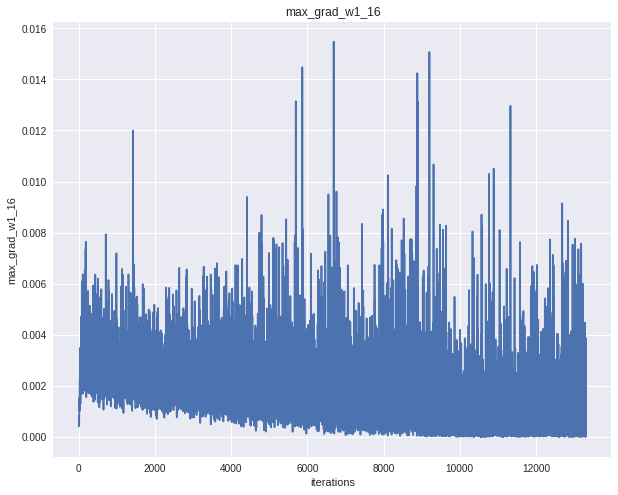

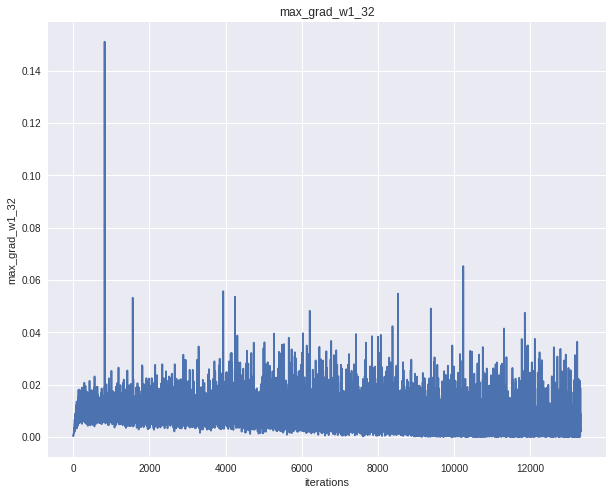

In [3]:
# Plot gradients norms for the entire learning process
grads_json_filename = os.path.join(FDIR, 'model_grads.json')
grads = [[], [], []]
grads_key = ['max_grad_w1_16', 'max_grad_w1_32', 'max_grad_w1_64']
if os.path.exists(grads_json_filename):
    with open(grads_json_filename, 'r') as fp:
        data = json.load(fp)
        for i, k in enumerate(grads_key):
            if data[0].get(k, None) is None:
                continue
            for batch_grads in data:
                grads[i].append(batch_grads[k])

def plot_grads(grads, title, x_label, y_label, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    # plt.subplot(2, 1, 1)
    plt.plot(grads)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
for i, g in enumerate(grads):
    if len(g) > 0:
        plot_grads(g, grads_key[i], 'iterations', grads_key[i])
        # pass

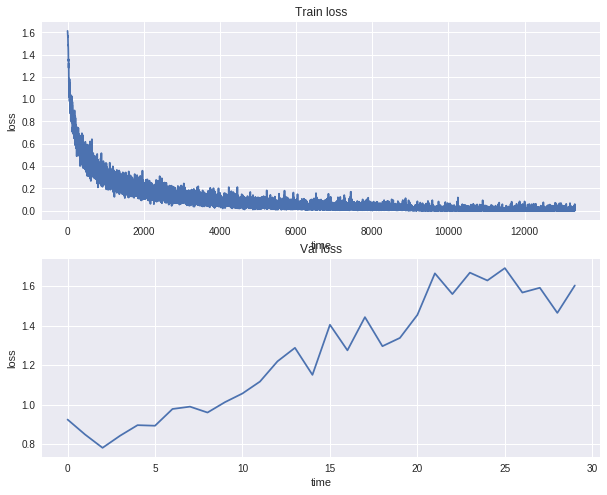

In [4]:
with open(json_file, 'r') as fp:
    data = json.load(fp)
# Loss history might not be of equal length.
train_loss_hist = data['train_loss_history']
val_loss_hist = data['val_loss_history']

plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(train_loss_hist)
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('time')
plt.subplot(2, 1, 2)
plt.plot(val_loss_hist)
plt.title('Val loss')
plt.ylabel('loss')
plt.xlabel('time')
plt.show()


In [5]:
if data.get('KL_loss_history', None) is not None:
    # Loss history might not be of equal length.
    KL_loss_hist = data['KL_loss_history']

    plt.figure(figsize=(10,8))
    plt.plot(KL_loss_hist)
    plt.title('KL loss')
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()


In [6]:
def get_conf(json_file, num_classes=26, json_key='conf'):
    with open(json_file, 'r') as fp:
        data = json.load(fp)
        conf = data.get(json_key, None)
    if conf is None:
        return
    # c1 = conf.split('\n')[1].split("]")[0].split("[ ")[1].split(" ")
    c1 = conf.split('\n')
    # print(c1)
    conf_mat, row_idx = np.zeros((num_classes, num_classes)), 0
    for i in c1:
        #pdb.set_trace()
        is_conf_row = False
        if ']' in i and '[[' in i:
            val = i.split(']')[0].split('[[')[1].split(' ')
            is_conf_row = True
        elif ']' in i and '[' in i:
            val = i.split(']')[0].split('[')[1].split(' ')
            is_conf_row = True
        if is_conf_row:
            col_idx = 0
            for v in val:
                if not len(v):
                    continue
                try:
                    conf_mat[row_idx, col_idx] = int(v)
                    col_idx = col_idx + 1
                except:
                    continue
            row_idx = row_idx + 1
            
    assert(row_idx == num_classes)
    conf_mat = conf_mat.astype(int)
    conf_mat = conf_mat[:num_classes,:num_classes]
    fdir = os.path.dirname(json_file)
    json_name = os.path.basename(json_file)[:-5]
    conf_file_name = fdir + '/' + 'conf_' + json_name + '.txt'
    # np.savetxt(conf_file_name, conf_mat, fmt='%d', delimiter=', ')
    return conf_mat


def plot_conf(norm_conf, shape=5):
  # Plot using seaborn
  # (this is style I used for ResNet matrix)
  plt.figure(figsize=(4,3))
  df_cm = pd.DataFrame(norm_conf)
  if shape == 7:
      labels = ['None', 'Nod', 'Up/Down', 'Tilt', 'Shake', 'Turn', 'Fwd/Back']
  elif shape == 5:
      labels = ['None', 'Nod', 'Tilt', 'Shake', 'Fwd/Back']
  elif shape == 11:
      labels = ['None', 'Nod', 'Jerk', 'Up', 'Down', 'Tick', 'Tilt', 'Shake', 'Turn', 'Forward','Back']
  elif shape == 4:
      labels = ['None', 'Nod', 'Tilt', 'Shake']
  else:
    print(shape)
    assert(False)
    
  sns.heatmap(df_cm, annot=True, cmap="Blues", yticklabels=labels, fmt=".2f")
  #sns.heatmap(df_cm, annot=True, cmap="Blues", yticklabels=labels)
  
  # This sets the yticks "upright" with 0, as opposed to sideways with 90.
  plt.yticks(rotation=0) 
    
  plt.show()

In [7]:
def get_sorted_checkpoints(fdir):
    # Checkpoint files are named as 'checkpoint_%d.json'
    checkpoint_map = {}
    for f in os.listdir(fdir):
        if f.endswith('json') and f.startswith('checkpoint'):
            checkpoint_num = int(f.split('checkpoint_')[-1].split('.')[0])
            checkpoint_map[checkpoint_num] = f
    sorted_checkpoints = []
    for k in sorted(checkpoint_map.keys()):
        v = checkpoint_map[k]
        sorted_checkpoints.append(v)
    return sorted_checkpoints


In [8]:
def best_f_scores(fdir, num_classes=5, json_key='conf'): 
    best_checkpoints = [None, None, None]
    best_3_fscores = [0, 0, 0]
    best_confs = [np.array(()), np.array(()), np.array(())]
    f1_weight_list = [1.0] * num_classes
    f1_weights = np.array(f1_weight_list)
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    all_checkpoints = {}

    for f in sorted_checkpoint_files:
        json_file = fdir + '/' + f
        conf = get_conf(json_file, num_classes, json_key=json_key)
        norm_conf = data_utils.normalize_conf(conf)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
                f, f1, kappa, wt_f1))
        plot_conf(norm_conf, conf.shape[0])
        max_idx = -1
        for i in range(len(best_3_fscores)):
            if best_3_fscores[i] > f1:
                break
            max_idx = i
        for j in range(max_idx):
            best_3_fscores[j] = best_3_fscores[j+1]
            best_confs[j] = best_confs[j+1]
            best_checkpoints[j] = best_checkpoints[j+1]

        best_3_fscores[max_idx] = f1
        best_confs[max_idx] = conf
        best_checkpoints[max_idx] = f
        
        all_checkpoints[f] = {}
        all_checkpoints[f]['f1'] = f1
        all_checkpoints[f]['wt_f1'] = wt_f1
        all_checkpoints[f]['kappa'] = kappa

    return best_3_fscores, best_confs, best_checkpoints, all_checkpoints

[[13265    42     4     6     3]
 [   39 13268     4     3     6]
 [    5     5 13302     4     4]
 [    5     1     3 13310     1]
 [    3     3     4     0 13310]]
file: <built-in method f of mtrand.RandomState object at 0x7f43e015b320>, f1: 0.998, kappa: 0.998, weighted-F1: 0.998


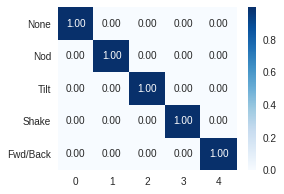

In [9]:
def plot_train_conf(fdir, num_classes=5):
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    if len(sorted_checkpoint_files) > 0:
        last_checkpoint = sorted_checkpoint_files[-1]
        json_file = fdir + '/' + last_checkpoint
        conf = get_conf(json_file, num_classes=num_classes, json_key='train_conf')
        print(conf)
        norm_conf = data_utils.normalize_conf(conf)
        f1_weight_list = [1.0] * num_classes
        f1_weights = np.array(f1_weight_list)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
            f, f1, kappa, wt_f1))
        plot_conf(norm_conf, conf.shape[0])

plot_train_conf(FDIR, num_classes=NUM_CLASSIFY)

file: checkpoint_1.json, f1: 0.545, kappa: 0.306, weighted-F1: 0.715


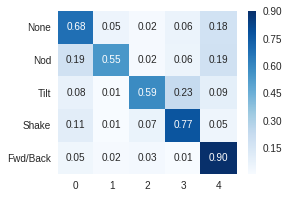

file: checkpoint_2.json, f1: 0.575, kappa: 0.361, weighted-F1: 0.736


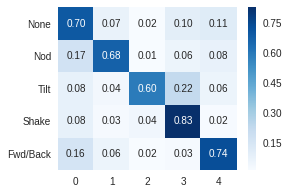

file: checkpoint_3.json, f1: 0.602, kappa: 0.448, weighted-F1: 0.774


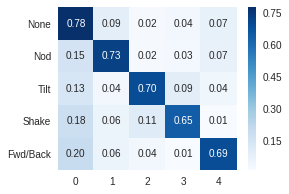

file: checkpoint_4.json, f1: 0.577, kappa: 0.448, weighted-F1: 0.746


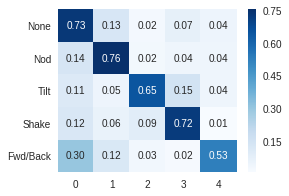

file: checkpoint_5.json, f1: 0.584, kappa: 0.468, weighted-F1: 0.753


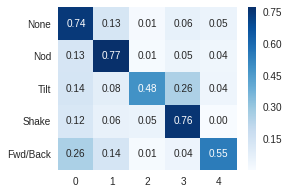

file: checkpoint_6.json, f1: 0.599, kappa: 0.488, weighted-F1: 0.768


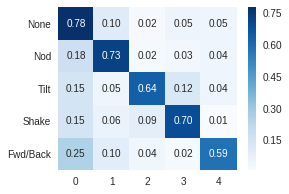

file: checkpoint_7.json, f1: 0.593, kappa: 0.492, weighted-F1: 0.754


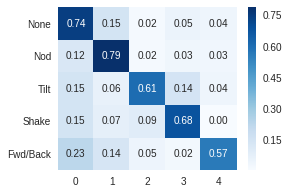

file: checkpoint_8.json, f1: 0.590, kappa: 0.492, weighted-F1: 0.759


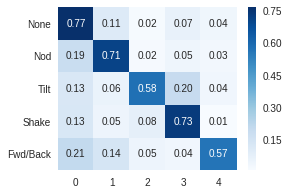

file: checkpoint_9.json, f1: 0.612, kappa: 0.527, weighted-F1: 0.771


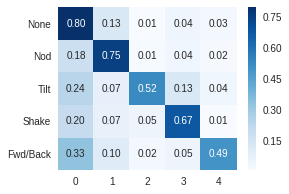

file: checkpoint_10.json, f1: 0.602, kappa: 0.521, weighted-F1: 0.771


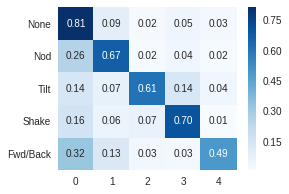

file: checkpoint_11.json, f1: 0.605, kappa: 0.526, weighted-F1: 0.764


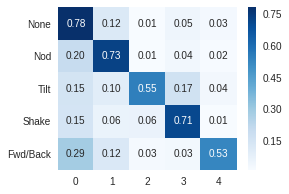

file: checkpoint_12.json, f1: 0.611, kappa: 0.522, weighted-F1: 0.764


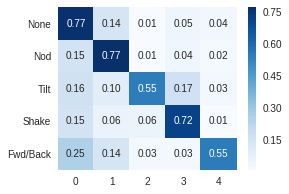

file: checkpoint_13.json, f1: 0.594, kappa: 0.501, weighted-F1: 0.762


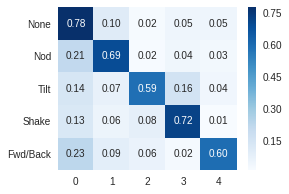

file: checkpoint_14.json, f1: 0.598, kappa: 0.516, weighted-F1: 0.754


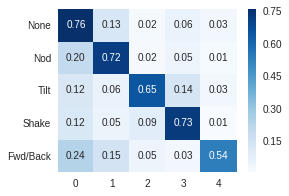

file: checkpoint_15.json, f1: 0.609, kappa: 0.527, weighted-F1: 0.774


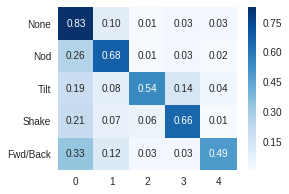

file: checkpoint_16.json, f1: 0.609, kappa: 0.538, weighted-F1: 0.764


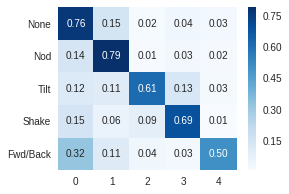

file: checkpoint_17.json, f1: 0.602, kappa: 0.535, weighted-F1: 0.770


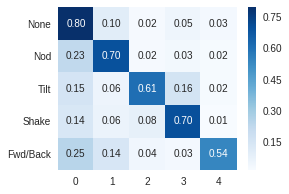

file: checkpoint_18.json, f1: 0.583, kappa: 0.496, weighted-F1: 0.760


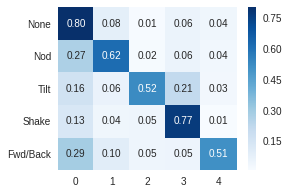

file: checkpoint_19.json, f1: 0.618, kappa: 0.548, weighted-F1: 0.783


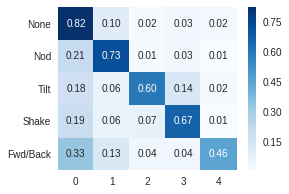

file: checkpoint_20.json, f1: 0.610, kappa: 0.538, weighted-F1: 0.782


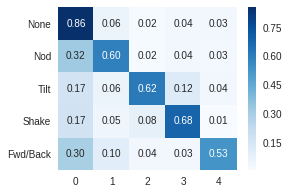

file: checkpoint_21.json, f1: 0.619, kappa: 0.543, weighted-F1: 0.776


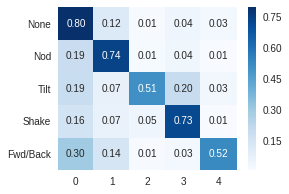

file: checkpoint_22.json, f1: 0.594, kappa: 0.509, weighted-F1: 0.756


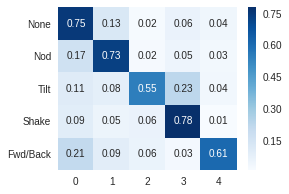

file: checkpoint_23.json, f1: 0.605, kappa: 0.535, weighted-F1: 0.767


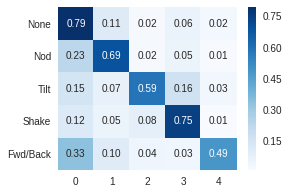

file: checkpoint_24.json, f1: 0.607, kappa: 0.535, weighted-F1: 0.765


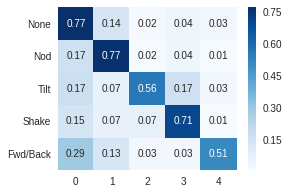

file: checkpoint_25.json, f1: 0.605, kappa: 0.541, weighted-F1: 0.763


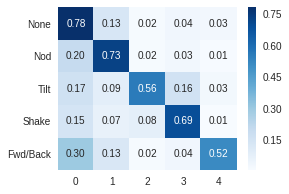

file: checkpoint_26.json, f1: 0.595, kappa: 0.518, weighted-F1: 0.761


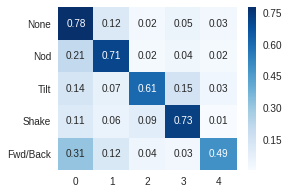

file: checkpoint_27.json, f1: 0.603, kappa: 0.547, weighted-F1: 0.774


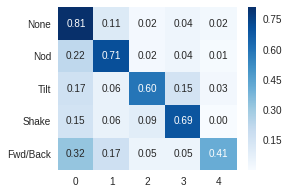

file: checkpoint_28.json, f1: 0.602, kappa: 0.537, weighted-F1: 0.765


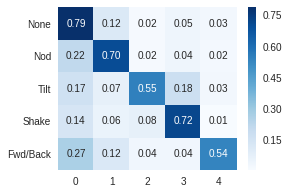

file: checkpoint_29.json, f1: 0.608, kappa: 0.561, weighted-F1: 0.782


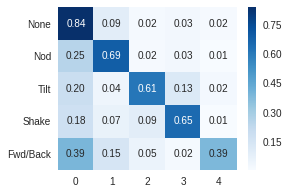

file: checkpoint_30.json, f1: 0.608, kappa: 0.547, weighted-F1: 0.771


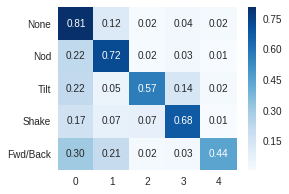

[('checkpoint_29.json',
  {'f1': 0.60820184532891786,
   'kappa': 0.56102179370959715,
   'wt_f1': 0.78208364129888042}),
 ('checkpoint_19.json',
  {'f1': 0.61790574267954534,
   'kappa': 0.54818155266033175,
   'wt_f1': 0.78296007504484821}),
 ('checkpoint_30.json',
  {'f1': 0.60817839923382566,
   'kappa': 0.54728869297169913,
   'wt_f1': 0.77126834941808964}),
 ('checkpoint_27.json',
  {'f1': 0.60290827849770323,
   'kappa': 0.54687432702879568,
   'wt_f1': 0.77385257915644012}),
 ('checkpoint_21.json',
  {'f1': 0.61928405162405875,
   'kappa': 0.54312459482160436,
   'wt_f1': 0.77581531649347202}),
 ('checkpoint_25.json',
  {'f1': 0.6046962779460382,
   'kappa': 0.54068418043660915,
   'wt_f1': 0.76322111332546727}),
 ('checkpoint_20.json',
  {'f1': 0.60979370605235583,
   'kappa': 0.5381909449148059,
   'wt_f1': 0.78213742444097134}),
 ('checkpoint_16.json',
  {'f1': 0.60912730331351639,
   'kappa': 0.53809415577884079,
   'wt_f1': 0.76427493962924398}),
 ('checkpoint_28.json',
  

In [12]:
_, _, _, all_checkpoint_results = best_f_scores(FDIR, num_classes=NUM_CLASSIFY)

best_kappa_results = sorted(all_checkpoint_results.items(), key=lambda x: x[1]['kappa'])[::-1]
best_f1_results = sorted(all_checkpoint_results.items(), key=lambda x: x[1]['f1'])[::-1]

pprint.pprint(best_kappa_results)

In [11]:
with open(json_file, 'r') as fp:
    data = json.load(fp)
    json_key = 'val_context_conf'
    if data.get(json_key) is not None:
        best_f_scores(FDIR, num_classes=8, json_key=json_key)